In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = False

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
from src.data_loader.classification import ClassifyDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "classification"
data_set_name = "detect_lvi"
batch_size = 8
on_memory = True
argumentation_proba = 0.8
target_size = (512,512)
interpolation = "bilinear"
class_mode = "binary"
# class_mode = "categorical"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/*/*")[:20]
valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/*/*")[:20]
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/*/*")[:20]
label_list = os.listdir(f"./datasets/{task}/{data_set_name}/train")

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}

train_data_loader = ClassifyDataloader(image_path_list=train_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       class_mode=class_mode,
                                       dtype=dtype
)
valid_data_loader = ClassifyDataloader(image_path_list=valid_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)
test_data_loader = ClassifyDataloader(image_path_list=test_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)

 [04/20] |##########                                        | (ETA:   0:00:00) 

0
1
2
3


 [09/20] |######################                            | (ETA:   0:00:00) 

4
5
6
7
8


 [14/20] |###################################               | (ETA:   0:00:00) 

9
10
11
12
13


 [19/20] |###############################################   | (ETA:   0:00:00) 

14
15
16
17
18


 [20/20] |##################################################| (Time:  0:00:00) 
 [04/20] |##########                                        | (ETA:   0:00:00) 

19
Total data num 20 with 2 classes
0
1
2
3


 [08/20] |####################                              | (ETA:   0:00:00) 

4
5
6
7


 [13/20] |################################                  | (ETA:   0:00:00) 

8
9
10
11
12


 [18/20] |#############################################     | (ETA:   0:00:00) 

13
14
15
16
17


 [20/20] |##################################################| (Time:  0:00:00) 


18
19
Total data num 20 with 2 classes
Total data num 20 with 2 classes


In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

grad_cam = False
transfer_learning = False
epoch_release_frozen = 10
transfer_train_mode = "include_deep_layer"
layer_name_frozen_to = "mixed4"

#  binary_sigmoid, categorical_sigmoid, categorical_softmax
activation = "binary_sigmoid"

# create the base pre-trained model~
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "include_deep_layer":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == layer_name_frozen_to:
                break

# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)

if grad_cam:
    x *= 1e-1
    keras_backend.set_floatx('float64')
    dense_dtype = "float64"
else:
    dense_dtype = "float32"
    
if activation == "binary_sigmoid":
    predictions = Dense(1, activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = BinaryCrossentropy(label_smoothing=0.01)
elif activation == "categorical_sigmoid":
    predictions = Dense(2, activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)
elif activation == "categorical_softmax":
    predictions = Dense(2, activation='softmax', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)

# this is the model we will train
model = Model(base_model.input, predictions)

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, today_weights_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = glob(f"{today_weights_path}/*.hdf5")[0]

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

In [5]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./weights/{task}/{data_set_name}/{today_str}/target_size_{target_size}/" 
today_logs_path = f"./logs/{task}/{data_set_name}/{today_str}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-3, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
# reduceLROnPlat = ReduceLROnPlateauBestWeight(
#     today_weight_path=today_weight_path,
#     monitor="val_loss",
#     factor=0.1,
#     patience=20,
#     verbose=1,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=5,
#     min_lr=1e-7)

csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


def make_model_trainable(epoch, model, target_epoch):
    if epoch > target_epoch:
        for layer in model.layers:
            layer.trainable = True
            
make_trainable_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: make_model_trainable(epoch, model, target_epoch=epoch_release_frozen)
)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [ ]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger, make_trainable_callback],
    initial_epoch=start_epoch
)

Epoch 1/200
1076/1076 [==============================] - 775s 703ms/step - loss: 0.7103 - accuracy: 0.5622 - val_loss: 0.6859 - val_accuracy: 0.5721
Epoch 2/200
1076/1076 [==============================] - 815s 758ms/step - loss: 0.6836 - accuracy: 0.5774 - val_loss: 0.6483 - val_accuracy: 0.5976
Epoch 3/200
1076/1076 [==============================] - 866s 804ms/step - loss: 0.6562 - accuracy: 0.6097 - val_loss: 0.9271 - val_accuracy: 0.5211
Epoch 4/200
1076/1076 [==============================] - 966s 896ms/step - loss: 0.6274 - accuracy: 0.6423 - val_loss: 1.8181 - val_accuracy: 0.6884
Epoch 5/200
1076/1076 [==============================] - 919s 854ms/step - loss: 0.6075 - accuracy: 0.6753 - val_loss: 0.5542 - val_accuracy: 0.7233
Epoch 6/200
1076/1076 [==============================] - 767s 712ms/step - loss: 0.5832 - accuracy: 0.6987 - val_loss: 0.5531 - val_accuracy: 0.7369
Epoch 7/200
1076/1076 [==============================] - 912s 846ms/step - loss: 0.5756 - accuracy: 0.7025

1076/1076 [==============================] - 935s 869ms/step - loss: 0.0561 - accuracy: 0.9921 - val_loss: 0.2855 - val_accuracy: 0.9229
Epoch 109/200
1076/1076 [==============================] - 870s 808ms/step - loss: 0.0542 - accuracy: 0.9938 - val_loss: 0.2838 - val_accuracy: 0.9248
Epoch 110/200
 831/1076 [======================>.......] - ETA: 2:48 - loss: 0.0541 - accuracy: 0.9922

In [6]:
weight_path_list = glob(f"./weights/classification/detect_lvi/2021-07-01/target_size_(512, 512)/*.hdf5")
weight_path_list.sort()
best_path = weight_path_list[0]
print(best_path)

./weights/classification/detect_lvi/2021-07-01/target_size_(512, 512)/weights_0.1769_0.2184_14.hdf5


In [7]:
target_data_loader = test_data_loader

target_data_loader.batch_size = 1
model.load_weights(best_path)
model_predicted = model.predict(target_data_loader)
ground_truth = np.array(list(target_data_loader.data_getter.class_dict.values()))

model.evaluate(target_data_loader)

1469/1469 [==============================] - 135s 91ms/step - loss: 0.0793 - accuracy: 0.9816


[0.07934682816267014, 0.9816201329231262]

In [62]:
thresh_hold = 0.25

negative_group_1 = np.where(model_predicted < thresh_hold)[0]
negative_group_2 = np.where(model_predicted != 0)[0]
negative_confirm = np.where(model_predicted == 0)[0]
negative_not_confirm = np.intersect1d(negative_group_1, negative_group_2)

positive_group_1 = np.where(model_predicted > thresh_hold)[0]
positive_group_2 = np.where(model_predicted != 1)[0]
postive_confirm = np.where(model_predicted == 1)[0]
postive_not_confirm = np.intersect1d(positive_group_1, positive_group_2)

ground_truth_negative = np.where(ground_truth == 0)[0]
ground_truth_positive = np.where(ground_truth == 1)[0]

true_negative = np.intersect1d(negative_group_1, ground_truth_negative)
true_positive = np.intersect1d(positive_group_1, ground_truth_positive)
false_negative = np.intersect1d(negative_group_1, ground_truth_positive)
false_positive = np.intersect1d(positive_group_1, ground_truth_negative)


In [63]:
print(len(negative_confirm))
print(len(negative_not_confirm))
print(len(postive_confirm))
print(len(postive_not_confirm))

0
727
0
742


In [64]:
print(len(negative_confirm))
print(len(negative_not_confirm))
print(len(postive_confirm))
print(len(postive_not_confirm))

0
727
0
742


In [65]:
print(false_negative)
print(false_positive)

[]
[  3  10  37  43  56  63  64  70  94 107 115 151 166 220 292 330 367 393
 415 446 451 471 510 518 528 539 562 564 593 596 597 606 610 613 614 617
 619 620 623 626 706 708]


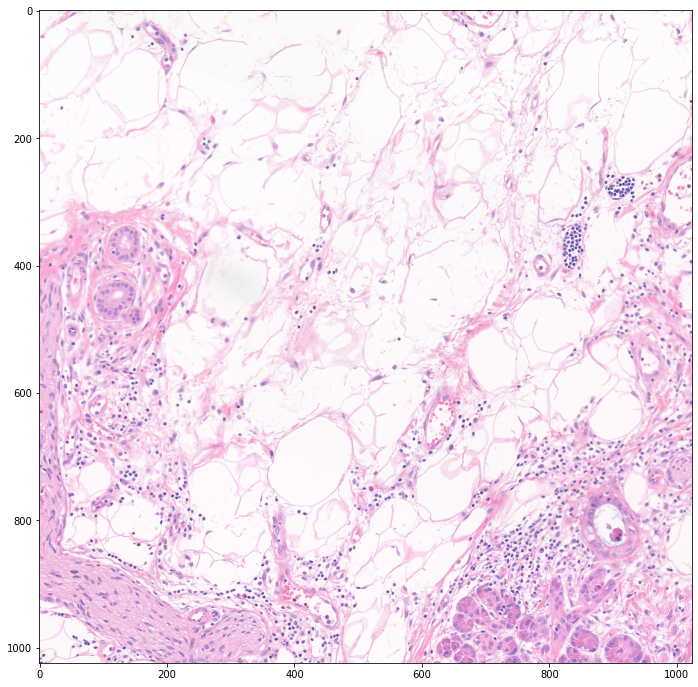

In [71]:
import cv2
from matplotlib import pyplot as plt

index = 37
image_array = cv2.imread(test_image_path_list[index], cv2.IMREAD_UNCHANGED)
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(image_array)
plt.show()

[[0.8714211]]
0.999999995108789
Predicted: 1


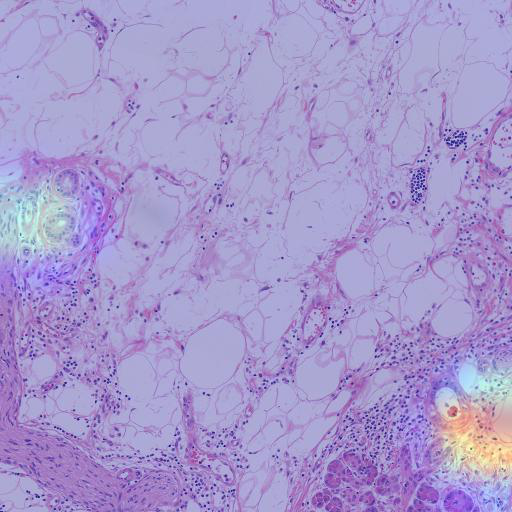

In [72]:
target_layer_name = "mixed10"

img_array_normalized = test_data_loader[index][0]

grad_model = make_grad_model(model, target_layer_name)

# Print what the top predicted class is
preds = model.predict(img_array_normalized)
preds_value = preds.flatten()[0]
preds_value = restore_sigmoid_value(preds_value, decrease_ratio=1e1)
predicted_label = decode_binary_classify_predictions(preds)
label = decode_binary_classify_predictions(predicted_label)
pred_index = None
# pred_index = label_to_index_dict[predicted_label]

print(preds)
print(preds_value)
print(f"Predicted: {predicted_label}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array_normalized, grad_model, pred_index=pred_index)

save_and_display_gradcam(img_array_normalized, heatmap, cam_path="cam.jpg", display_cam=True)

In [26]:
import cv2
import os
import numpy as np
from PIL import Image
def imread(img_path, channel=None):
    img_byte_stream = open(img_path.encode("utf-8"), "rb")
    img_byte_array = bytearray(img_byte_stream.read())
    img_numpy_array = np.asarray(img_byte_array, dtype=np.uint8)
    img_numpy_array = cv2.imdecode(
        img_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "rgb":
        img_numpy_array = cv2.cvtColor(
            img_numpy_array, cv2.COLOR_BGR2RGB)
    if len(img_numpy_array.shape) == 2:
        img_numpy_array = np.expand_dims(img_numpy_array, axis=-1)
    return img_numpy_array

from tensorflow import keras
import matplotlib.cm as cm

def get_last_conv_name(model):
    layer_names = [layer.name for layer in model.layers]
    conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
    last_conv_name = conv_layer_name[-1]
    
    return last_conv_name

def get_img_array(img_path, channel="rgb"):
    
    img_array = imread(img_path, channel="rgb")
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def make_grad_model(model, target_layer_name):
    # Model input: model.input
    # Model output: [last_conv_layer_outputs, model.outputs]
    grad_model = keras.models.Model(
        model.input, [model.get_layer(target_layer_name).output, model.output]
    )
    return grad_model

def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    # compute
    # 1. last_conv_layer_output
    # 2. class_channel value in prediction
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # compute gradient 
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # compute gradient channel mean 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # compute matmul(last_conv_layer_output, pooled_grads)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array_normalized, heatmap, cam_path="cam.jpg", alpha=0.4, display_cam=True):
    # Load the original image
    img_array = (img_array_normalized + 1) * 127.5
    img_array = img_array.astype('uint8')
    img_array = img_array[0]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if display_cam:
        display(Image.open(cam_path))


def decode_classify_predictions(pred_array, index_to_label_dict):
    predicted_index = np.sum(np.argmax(preds, axis=1))
    predicted = index_to_label_dict[predicted_index]
    
    return predicted

def decode_binary_classify_predictions(pred_array):
    predicted = np.round(pred_array).astype("int32")
    predicted = predicted.flatten()[0]
    return predicted

def restore_sigmoid_value(y, decrease_ratio=1e1):
    original_x = np.log(y/(1-y))
    restored_x = decrease_ratio*original_x
    new_y = 1/(1+np.exp(-restored_x))
    return new_y
